<a href="https://colab.research.google.com/github/czuniga76/S4Model_Tests/blob/main/s4_inv_pendulum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# S4 implemntation from https://github.com/TariqAHassan/S4Torch.git

In [1]:
from google.colab import drive
drive.mount("/content/MyDrive/")

Mounted at /content/MyDrive/


In [2]:
!ls /content/MyDrive/MyDrive/S4Tariq

dev_requirements.txt	       README.md	      s4torch
experiments		       requirements.txt       setup.cfg
inv_pendulum_5000episodes.npy  s4_5000_blocks2.model  setup.py
inv_pendulum_episodes.npy      s4_5000_blocks4.model  train.py
LICENSE			       s4_5000.model


In [ ]:
!ls /content/MyDrive
!git clone https://github.com/TariqAHassan/S4Torch.git /content/MyDrive/MyDrive/S4Tariq/

MyDrive
Cloning into '/content/MyDrive/MyDrive/S4Tariq'...
remote: Enumerating objects: 2132, done.
remote: Counting objects: 100% (193/193), done.
remote: Compressing objects: 100% (102/102), done.
remote: Total 2132 (delta 116), reused 144 (delta 90), pack-reused 1939 (from 1)
Receiving objects: 100% (2132/2132), 266.45 KiB | 2.22 MiB/s, done.
Resolving deltas: 100% (1376/1376), done.


In [3]:
import sys
sys.path.append("/content/MyDrive/MyDrive/S4Tariq/")

In [20]:

import math
import time
from multiprocessing import cpu_count
import torch
from torch import nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader

In [5]:
# inv pendulum data. Simple problem for initial testing.
# https://github.com/dylewsky/Data_Driven_Science_Python_Demos/blob/master/CH08/CH08_SEC07_1_LQR.ipynb


import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import animation, rc
from IPython.display import HTML
#from control.matlab import *
#from control import place
#import slycot
from scipy import integrate
# Python control toolbox available at https://python-control.readthedocs.io/

plt.rcParams['figure.figsize'] = [8, 8]
plt.rcParams.update({'font.size': 18})
plt.rcParams['animation.html'] = 'jshtml'

In [6]:
m = 1
M = 5
L = 2
g = -10
d = 1

b = 1 # pendulum up (b=1)

A = np.array([[0,1,0,0],\
              [0,-d/M,b*m*g/M,0],\
              [0,0,0,1],\
              [0,-b*d/(M*L),-b*(m+M)*g/(M*L),0]])

B = np.array([0,1/M,0,b/(M*L)]).reshape((4,1))

print(np.linalg.eig(A)[0])       # Eigenvalues
#print(np.linalg.det(ctrb(A,B)))  # Determinant of controllability matrix

[ 0.         -2.431123   -0.23363938  2.46476238]


In [7]:
## ODE RHS Function Definition
def pendcart(x,t,m,M,L,g,d,uf):
    u = uf(x) # evaluate anonymous function at x
    Sx = np.sin(x[2])             # x[2] is angular velocity, x[3] angle
    Cx = np.cos(x[2])
    D = m*L*L*(M+m*(1-Cx**2))

    dx = np.zeros(4)
    dx[0] = x[1]
    dx[1] = (1/D)*(-(m**2)*(L**2)*g*Cx*Sx + m*(L**2)*(m*L*(x[3]**2)*Sx - d*x[1])) + m*L*L*(1/D)*u
    dx[2] = x[3]
    dx[3] = (1/D)*((m+M)*m*g*L*Sx - m*L*Cx*(m*L*(x[3]**2)*Sx - d*x[1])) - m*L*Cx*(1/D)*u;

    return dx

In [13]:
## Simulate closed-loop system
T = 10
Dt = 0.001
N = int(T/DT)
tspan = np.arange(0,T,Dt)
x0 = np.array([-1,0,np.pi+0.1,0]) # Initial condition
wr = np.array([1,0,np.pi,0])      # Reference position
u = lambda x: -np.sin(x[2]) # lambda x: -K@(x-wr)           # Control law
ts = time.time()
x = integrate.odeint(pendcart,x0,tspan,args=(m,M,L,g,d,u))
te = time.time()
print(te-ts)
tstep = (te-ts)/N
print(tstep)


0.008039474487304688
8.039474487304687e-07


(10000, 4)


Text(0.5, 1.0, 'Pendulum Angle vs Time')

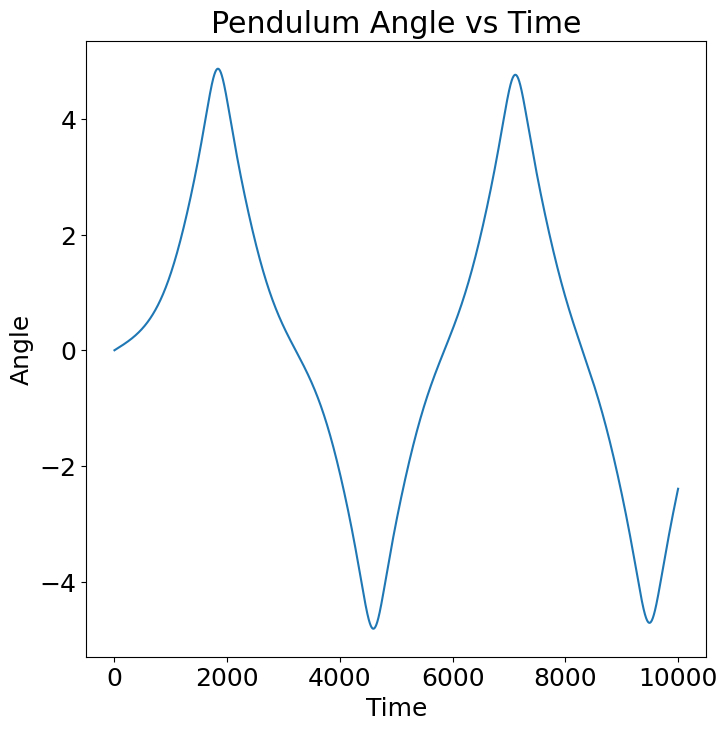

In [25]:
print(x.shape)
plt.plot(x[:,3])
plt.xlabel("Time")
plt.ylabel("Angle")
plt.title("Pendulum Angle vs Time")

In [ ]:
def create_training_data(num_episodes=10):
  tspan = np.arange(0,10,0.001)
  T = len(tspan)
  num_vars = 5
  g = -10
  episode_array = np.zeros((num_episodes,T,num_vars))
  for episode in range(num_episodes):
    #print(episode)
    # create different episode conditions. TODO, revise data to be more realistic. Parameters may vary because of noise but not that much
    m = 1 + 5*np.random.random()
    M = 4 + 6*np.random.random()
    L = 2 + 6*np.random.random()
    d = 1 + 2*np.random.random()

    b = 1 # pendulum up (b=1)

    x0 = np.array([-1,0,np.pi+0.1,0]) # Initial condition
    wr = np.array([1,0,np.pi,0])      # Reference position
    u = lambda x: -np.sin(x[2]) # simple control law

    x = integrate.odeint(pendcart,x0,tspan,args=(m,M,L,g,d,u))
    episode_array[episode,:,:4] = x
    episode_array[episode,:,4] = -np.sin(x[:,2])
  return episode_array


In [ ]:
episode_array = create_training_data()


(10, 10000, 5)


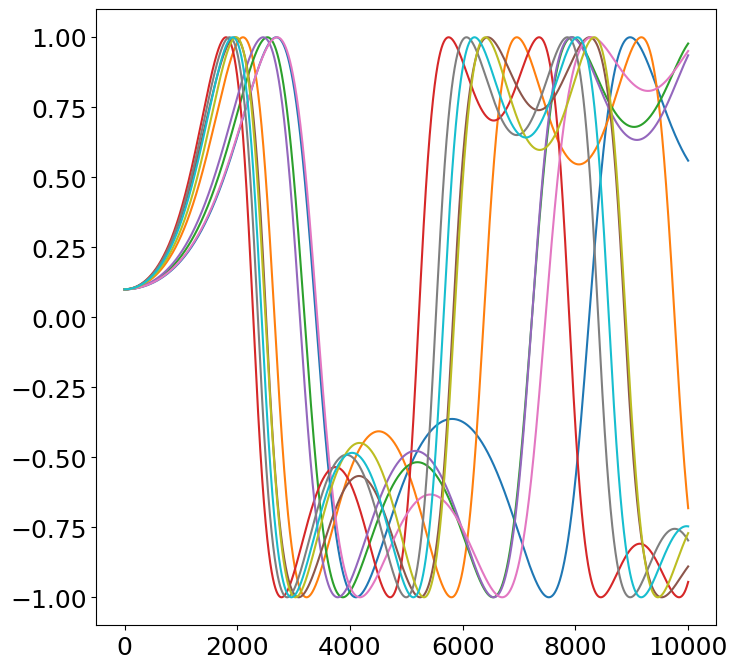

In [ ]:
print(episode_array.shape)
for i in range(10):
  plt.plot(episode_array[i,:,-1])

In [ ]:
episode_array = create_training_data(5000)


In [ ]:
np.save("/content/MyDrive/MyDrive/S4Tariq/inv_pendulum_5000episodes",episode_array)   # preloaded data

In [9]:
episode_array = np.load("/content/MyDrive/MyDrive/S4Tariq/inv_pendulum_5000episodes.npy")
print(episode_array.shape)

(5000, 10000, 5)


X ,y  (5000, 10000) (5000, 10000)


Text(0, 0.5, 'angle')

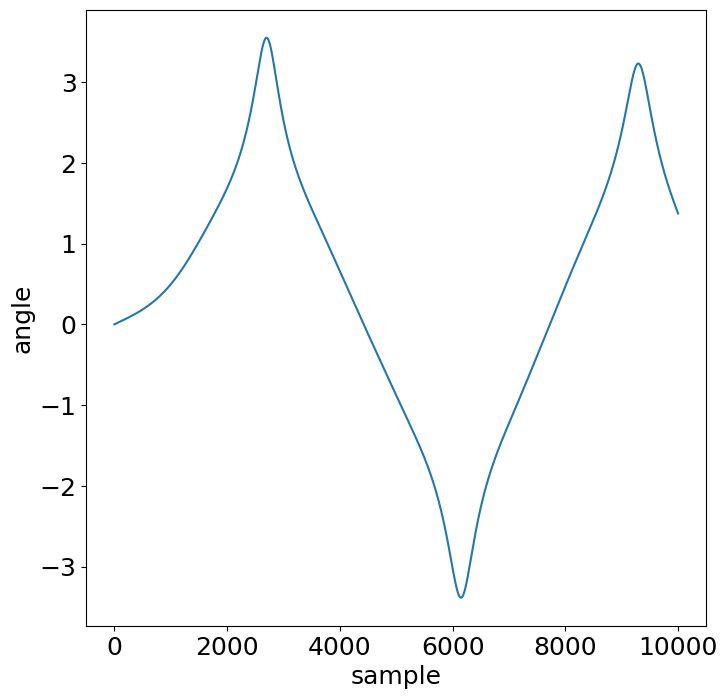

In [26]:
X = episode_array[:,:,-1]      # external force
y = episode_array[:,:,-2]      # angle
print("X ,y ",X.shape, y.shape)
plt.plot(y[10,:])
plt.xlabel("sample")
plt.ylabel("angle")

In [16]:
from sklearn.model_selection import train_test_split

# Assuming X is your feature matrix and y is your target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size=0.2,random_state=42)
print(X_train.shape,X_val.shape,X_test.shape)

(3200, 10000) (800, 10000) (1000, 10000)


In [17]:
X_train = np.expand_dims(X_train,-1)
X_val = np.expand_dims(X_val,-1)
X_test = np.expand_dims(X_test,-1)
y_train = np.expand_dims(y_train,-1)
y_val = np.expand_dims(y_val,-1)
y_test = np.expand_dims(y_test,-1)

In [21]:
xmax = np.abs(np.max(X_train))
ymax = np.abs(np.max(y_train))
X_train = X_train/xmax
X_val = X_val/xmax
X_test = X_test/xmax
y_train = y_train/ymax
y_val = y_val/ymax
y_test = y_test/ymax


In [22]:
class PendulumDataset(torch.utils.data.Dataset):
    def __init__(self, X_array,y_array):
        self.X_array = X_array.astype(np.float32)
        self.y_array = y_array.astype(np.float32)

    # get sample
    def __getitem__(self, idx):
        X = self.X_array[idx]
        y = self.y_array[idx]
        return  torch.from_numpy(X),torch.from_numpy(y)

    def __len__(self):
        return len(self.X_array)

In [23]:
train_dataset = PendulumDataset(X_train,y_train)
val_dataset = PendulumDataset(X_val,y_val)
test_dataset = PendulumDataset(X_test,y_test)
for X,y in train_dataset:
  print(X.shape,y.shape,X.dtype)
  break
batch_size = 64

train_dataloader = torch.utils.data.DataLoader(
            train_dataset,
            batch_size=batch_size,
            shuffle=True,
)
val_dataloader = torch.utils.data.DataLoader(
            val_dataset,
            batch_size=batch_size,
            shuffle=True,
)
test_dataloader = torch.utils.data.DataLoader(
            test_dataset,
            batch_size=batch_size,
            shuffle=True,
)

for X,y in test_dataloader:
  print(X.shape)
#  break

torch.Size([10000, 1]) torch.Size([10000, 1]) torch.float32
torch.Size([64, 10000, 1])
torch.Size([64, 10000, 1])
torch.Size([64, 10000, 1])
torch.Size([64, 10000, 1])
torch.Size([64, 10000, 1])
torch.Size([64, 10000, 1])
torch.Size([64, 10000, 1])
torch.Size([64, 10000, 1])
torch.Size([64, 10000, 1])
torch.Size([64, 10000, 1])
torch.Size([64, 10000, 1])
torch.Size([64, 10000, 1])
torch.Size([64, 10000, 1])
torch.Size([64, 10000, 1])
torch.Size([64, 10000, 1])
torch.Size([40, 10000, 1])


In [32]:
from s4torch import S4Model
N = 8           # inner dimension of S4 model. Usually higher but problem has low dimensionality
d_input = 1
d_model = 4
d_output = 1
n_blocks = 1    # simple problem so don't expect to need deep models
seq_len = 10000


u = torch.randn(1, seq_len, d_input)

s4model = S4Model(
    d_input,
    d_model=d_model,
    d_output=d_output,
    n_blocks=n_blocks,
    n=N,
    l_max=seq_len,
    norm_type=None,
    collapse=False,  # average predictions over time prior to decoding
)

In [30]:
def train_loop(dataloader, model, loss_fn, optimizer,device,batch_size=16):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    model = model.to(device)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        X = X.to(device)
        y = y.to(device)
        pred = model(X)

        #pred = model(X)
        #print(" y , pred ",y.shape,pred.shape)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test_loop(dataloader, model, loss_fn, device):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    model = model.to(device)
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)
            #pred = model(to_sequence(X))
            pred = model(X)
            #print(" y , pred ",y.shape,pred.shape)
            test_loss += loss_fn(pred, y).item()
            #correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [33]:
loss_fn = nn.MSELoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
optimizer = torch.optim.Adam(s4model.parameters(), lr=1e-3)

epochs = 15  # simple training loop


for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, s4model, loss_fn, optimizer, device)
    print(" validating")
    test_loop(val_dataloader, s4model, loss_fn, device)

print("Done!")

Epoch 1
-------------------------------
loss: 0.318485  [   64/ 3200]
 validating
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.117849 

Epoch 2
-------------------------------
loss: 0.116364  [   64/ 3200]
 validating
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.079707 

Epoch 3
-------------------------------
loss: 0.085575  [   64/ 3200]
 validating
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.072562 

Epoch 4
-------------------------------
loss: 0.078842  [   64/ 3200]
 validating
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.066389 

Epoch 5
-------------------------------
loss: 0.068500  [   64/ 3200]
 validating
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.034162 

Epoch 6
-------------------------------
loss: 0.037195  [   64/ 3200]
 validating
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.025609 

Epoch 7
-------------------------------
loss: 0.029205  [   64/ 3200]
 validating
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.022986 

Epoch 8
-------------------------------
loss: 0.025020  [   64/ 3200]

In [34]:
torch.save(s4model,"/content/MyDrive/MyDrive/S4Tariq/s4_test.model")

In [37]:
def eval_loop(dataloader, model, loss_fn, device):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    model = model.to(device)
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for i,(X, y) in enumerate(dataloader):
            X = X.to(device)
            y = y.to(device)
            #pred = model(to_sequence(X))
            pred = model(X)
            #print(" y , pred ",y.shape,pred.shape)
            test_loss += loss_fn(pred, y).item()
            #correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            print(pred.shape)
            pred = pred.detach().cpu().numpy()
            y = y.detach().cpu().numpy()
            plt.plot(y[0,:,0])
            #plt.figure()
            plt.plot(pred[0,:,0])
            plt.legend(["y","pred"])
            plt.figure()
            if i > 4:
                break

    test_loss /= num_batches
    correct /= size
    print(f" Avg loss: {test_loss:>8f} \n")

torch.Size([64, 10000, 1])
torch.Size([64, 10000, 1])
torch.Size([64, 10000, 1])
torch.Size([64, 10000, 1])
torch.Size([64, 10000, 1])
torch.Size([64, 10000, 1])
 Avg loss: 0.006299 



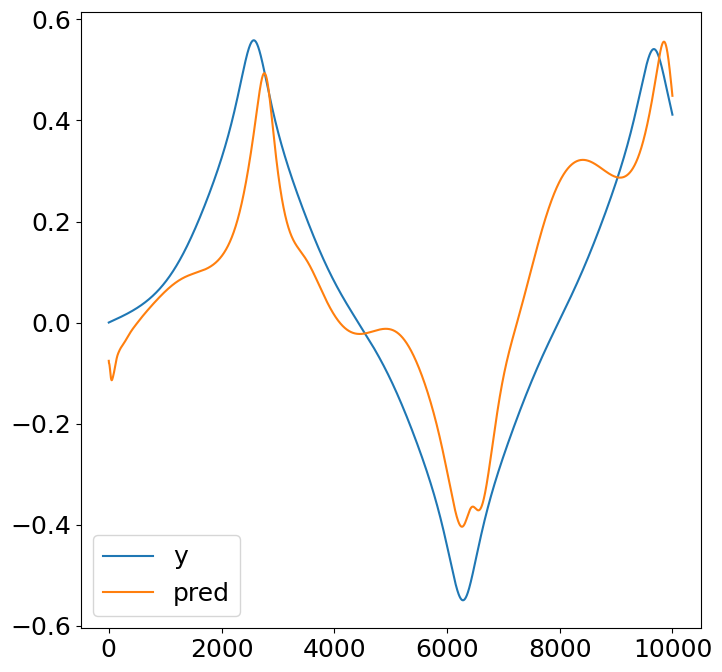

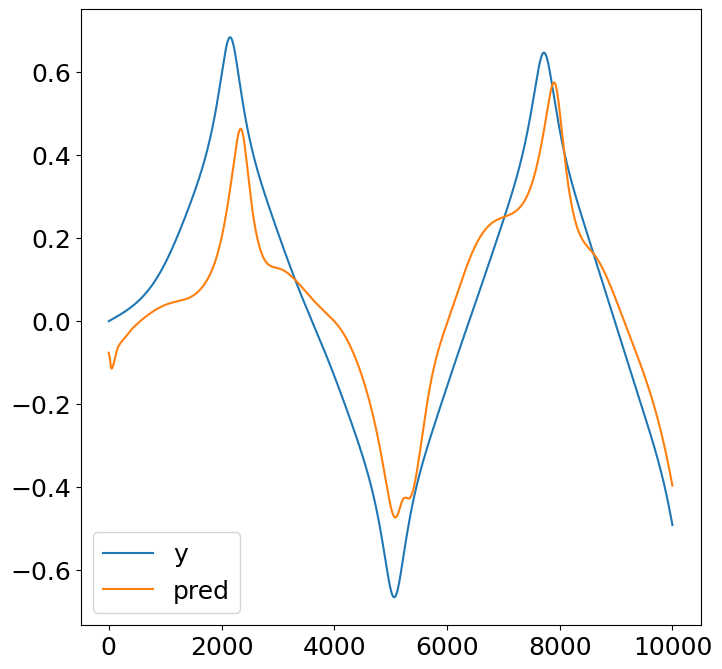

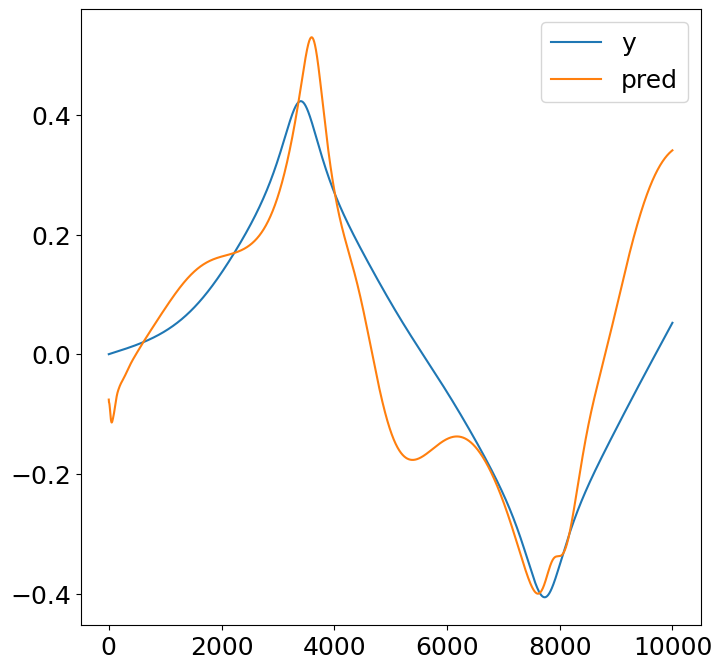

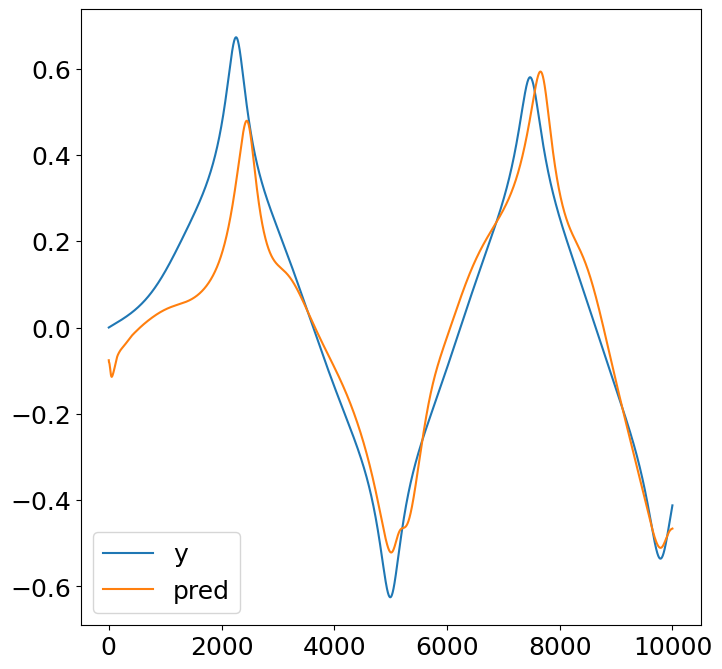

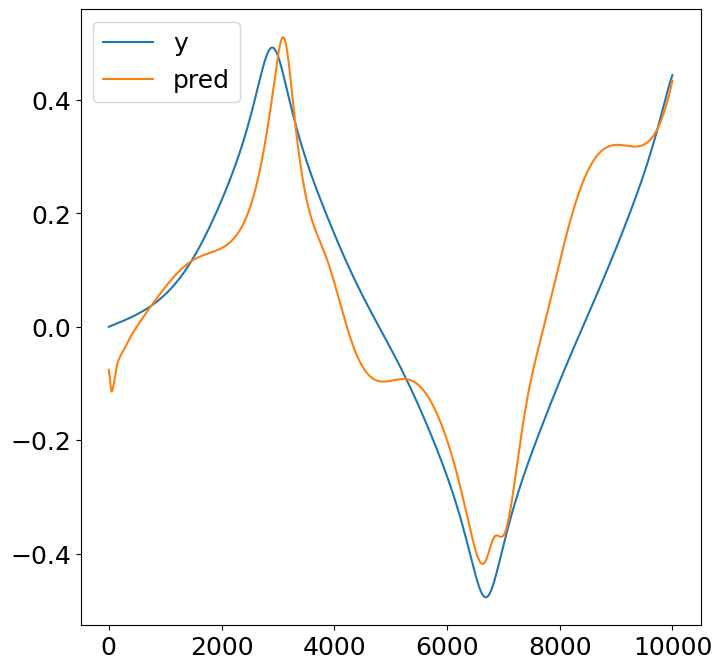

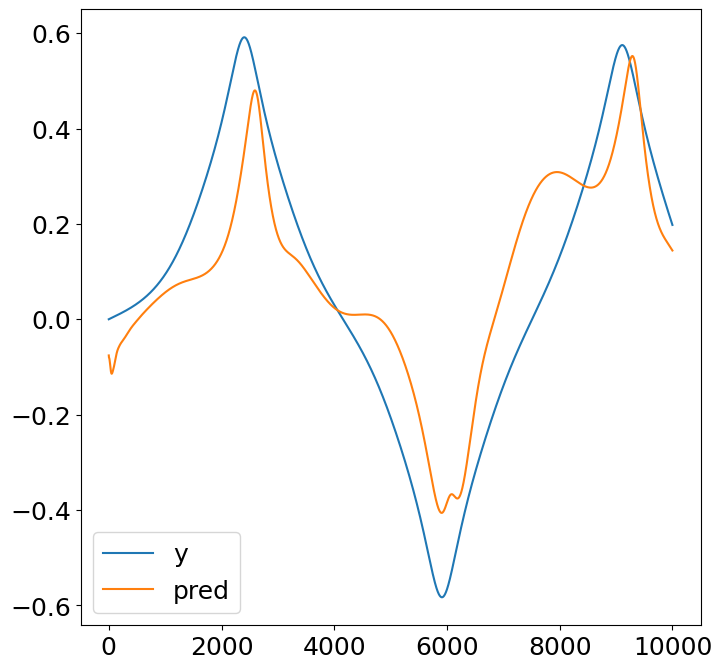

<Figure size 800x800 with 0 Axes>

In [38]:
eval_loop(test_dataloader, s4model, loss_fn, device)